In [1]:
data <- readr::read_csv("Archivos/Train real state.csv",
                        show_col_types = FALSE)

data <- data[c(-nrow(data), -(nrow(data) - 1)), ]

mapped_times <- list()
mapped_times['no_bus_stop_nearby'] <- 30
mapped_times['15min~20min'] <- 17.5
mapped_times['10min~15min'] <- 12.5
mapped_times['5min~10min'] <- 7.5
mapped_times['0~5min'] <- 2.5
mapped_times['0-5min'] <- 2.5

data$TimeToBusStop <- unlist(mapped_times[data$TimeToBusStop])
data$TimeToSubway <- unlist(mapped_times[data$TimeToSubway])

head(data)

SalePrice,YearBuilt,YrSold,MonthSold,Size.sqf.,Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot.Ground.,⋯,N_FacilitiesNearBy.Mall.,N_FacilitiesNearBy.ETC.,N_FacilitiesNearBy.Park.,N_SchoolNearBy.Elementary.,N_SchoolNearBy.Middle.,N_SchoolNearBy.High.,N_SchoolNearBy.University.,N_FacilitiesInApt,N_FacilitiesNearBy.Total.,N_SchoolNearBy.Total.
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
141592,2006,2007,8,814,3,terraced,individual_heating,management_in_trust,111,⋯,1,1,0,3,2,2,2,5,6,9
51327,1985,2007,8,587,8,corridor,individual_heating,self_management,80,⋯,1,2,1,2,1,1,0,3,12,4
48672,1985,2007,8,587,6,corridor,individual_heating,self_management,80,⋯,1,2,1,2,1,1,0,3,12,4
221238,1993,2007,8,1761,3,mixed,individual_heating,management_in_trust,523,⋯,1,5,0,4,3,5,5,4,14,17
78318,1992,2007,8,644,2,mixed,individual_heating,self_management,142,⋯,1,1,0,3,3,4,4,3,9,14
61946,1993,2007,8,644,10,mixed,individual_heating,management_in_trust,523,⋯,1,5,0,4,3,5,5,4,14,17


Warning message:
“not plotting observations with leverage one:
  3039”


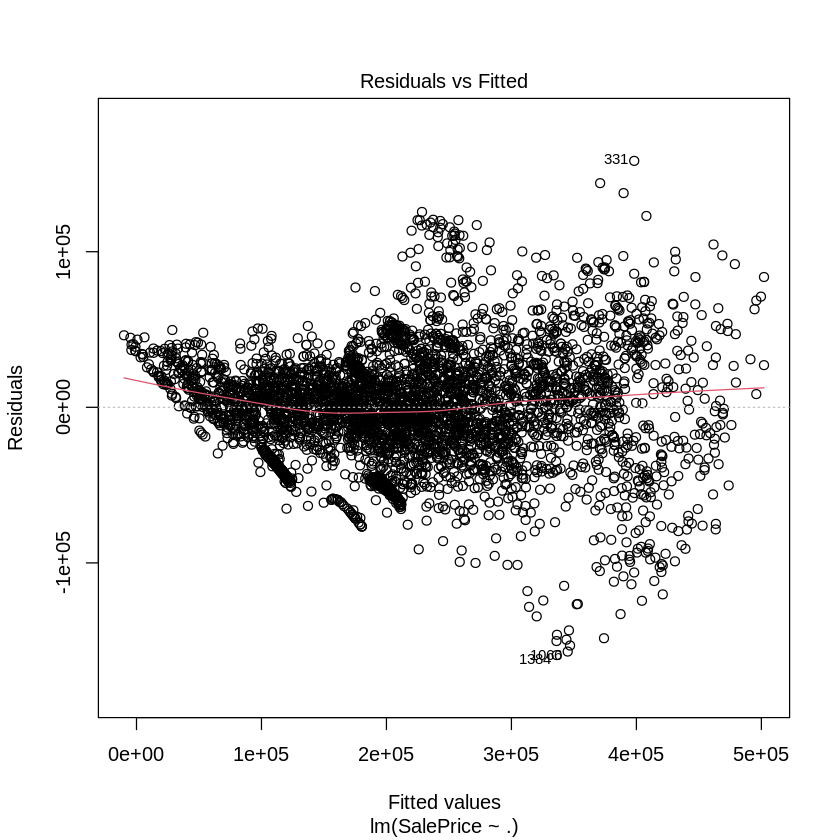

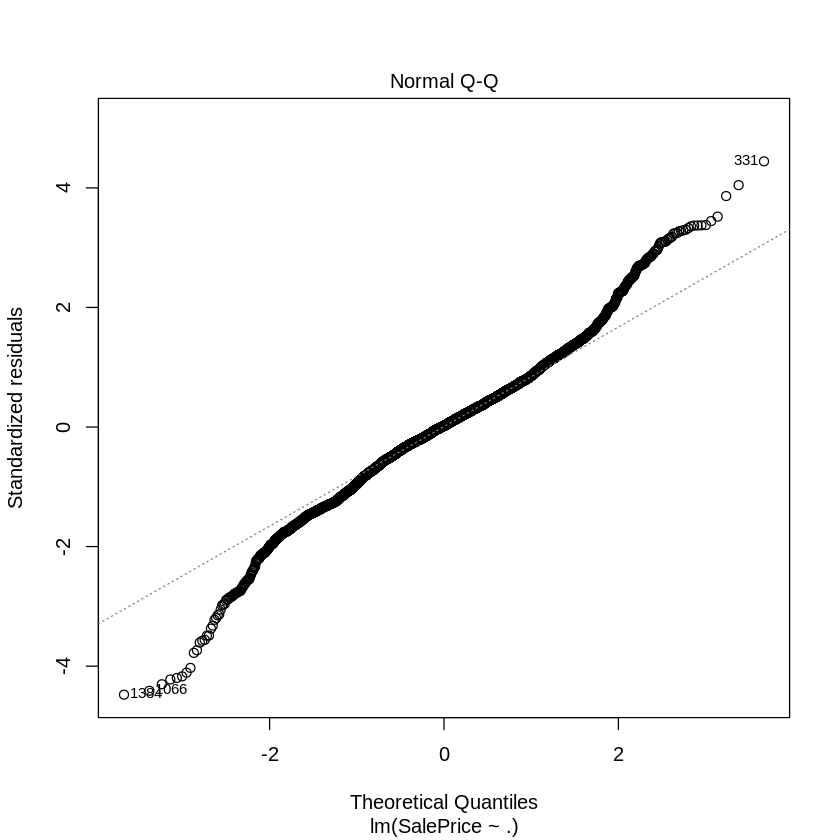

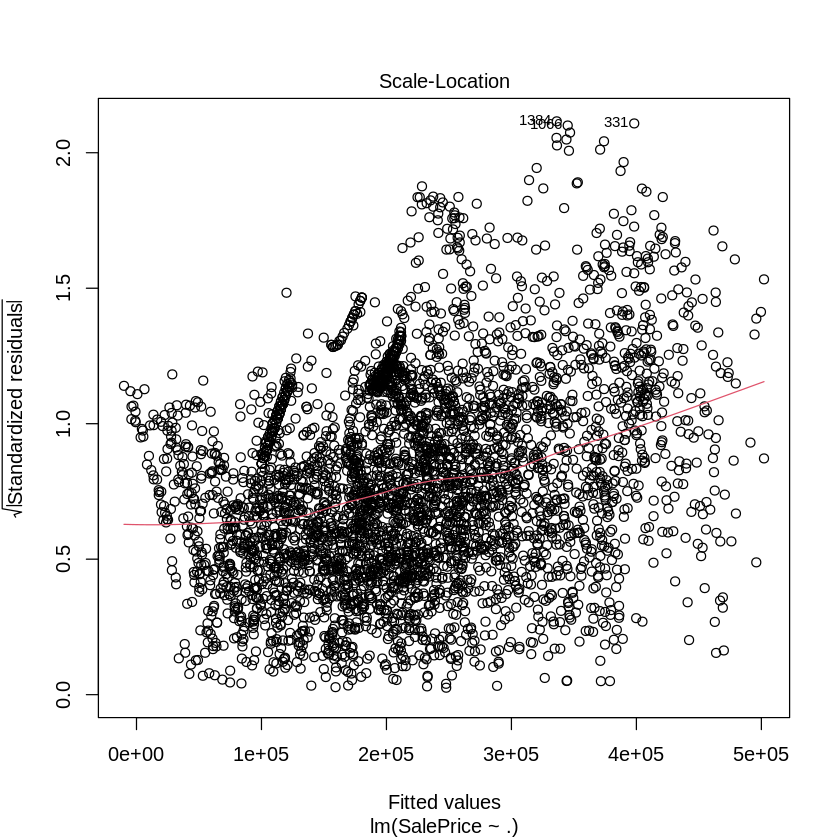

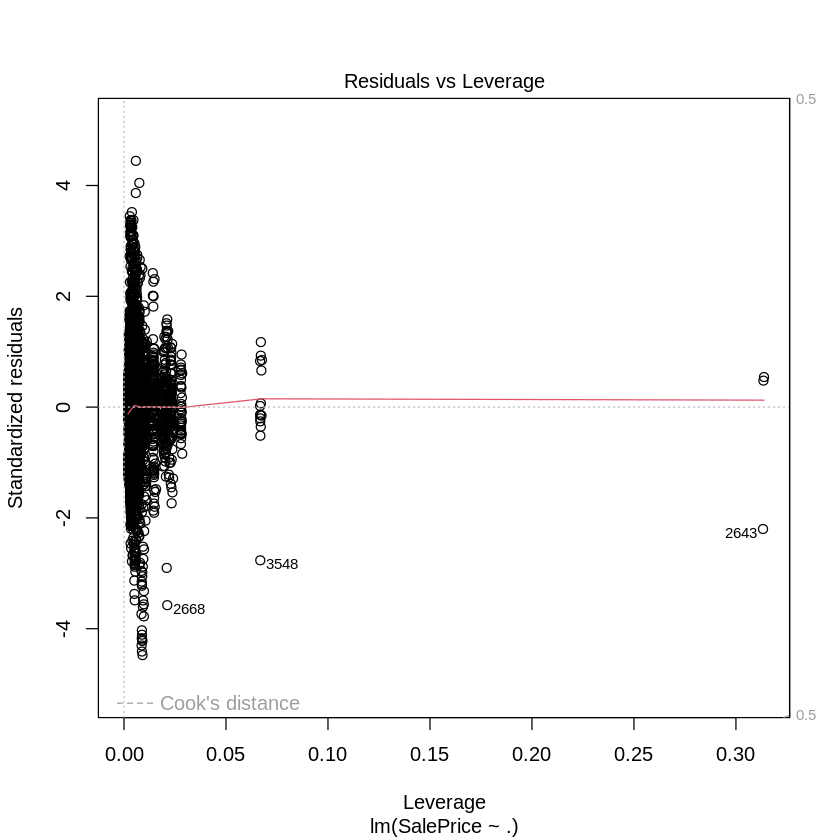

In [2]:
plot(lm(SalePrice ~ ., data = data))

In [3]:
keep_outliers <- TRUE

# Iterativamente quita outliers y recalcula el modelo, volviendo a hacer selección de features desde cero.

iter <- 4

for(re in 1:iter){   

    data_complete <- as.data.frame(model.matrix(~ (SubwayStation + HallwayType + HeatingType)
                                                  * (. - SalePrice) - 1,
                                            data = data))
    
    for (i in colnames(data_complete)) {
        name <- paste("log_", i, sep = "")
        data_complete[, name] <- log(data_complete[, i])
        name <- paste("squared_", i, sep = "")
        data_complete[, name] <- data_complete[, i] ^ 2
        name <- paste("inverse_", i, sep = "")
        data_complete[, name] <- 1 / data_complete[, i]
        name <- paste("sqrt_", i, sep = "")
        data_complete[, name] <- sqrt(data_complete[, i])
    }
    
    data_complete <- data_complete[, colSums(is.na(data_complete)) == 0]
    data_complete <- data_complete[, is.infinite(colSums(data_complete)) == 0]
    
    data_complete[, "SalePrice"] <- sqrt(data$SalePrice)
    data_complete <- data_complete[keep_outliers, ]

    modelo <- lm(SalePrice ~ .,
             data = data_complete)

    missing <- numeric()

    for(i in 1:length(modelo$coefficients)){
        if(is.na(modelo$coefficients[i])){
            missing <- c(missing, i - 1)
        }
    }
   
    data_complete <- data_complete[, -missing]
    
    modelos <- leaps::regsubsets(SalePrice ~ .,
                  data = data_complete,
                  nvmax = NULL,
                  method = "forward")
    
    sm <- summary(modelos)
    
    chosen <- 20
    
    for(i in 2:(ncol(data_complete) - 2)) {
        if(sm$adjr2[i - 1] > 0.9){
            chosen <- i - 1
            break
        }
    }
    
    selected_features <- names(coef(modelos, chosen))[-1]
    
    modelo <- lm(reformulate(selected_features, response = "SalePrice") , data = data_complete)
    
    cooks_dist <- cooks.distance(modelo)
    keep_outliers <- c(keep_outliers, cooks_dist < (2.5 * mean(cooks_dist, na.rm = TRUE)))

}

In [4]:
summary(modelo)


Call:
lm(formula = reformulate(selected_features, response = "SalePrice"), 
    data = data_complete)

Residuals:
     Min       1Q   Median       3Q      Max 
-171.023  -19.763    2.294   21.736  166.003 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     -4.081e+04  4.339e+02  -94.06   <2e-16 ***
YearBuilt                        3.906e+00  8.032e-02   48.62   <2e-16 ***
YrSold                           1.603e+01  2.131e-01   75.23   <2e-16 ***
`HallwayTypeterraced:Size.sqf.`  3.725e-02  1.559e-03   23.89   <2e-16 ***
log_Size.sqf.                    1.700e+02  2.033e+00   83.62   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 35.8 on 3599 degrees of freedom
  (6514 observations deleted due to missingness)
Multiple R-squared:  0.9047,	Adjusted R-squared:  0.9046 
F-statistic:  8542 on 4 and 3599 DF,  p-value: < 2.2e-16


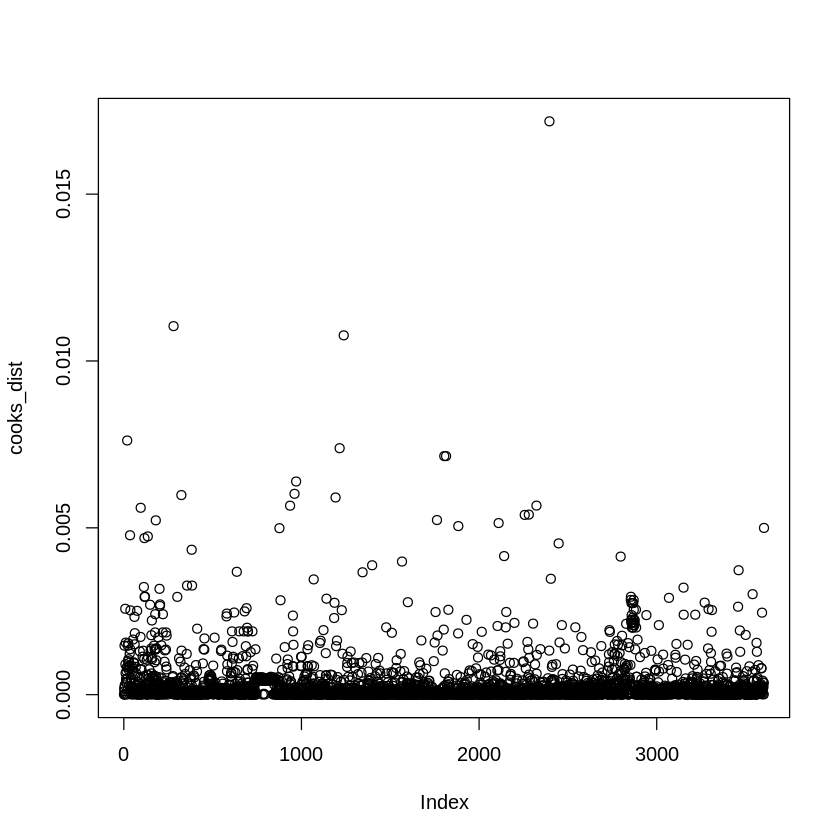

In [5]:
plot(cooks_dist)

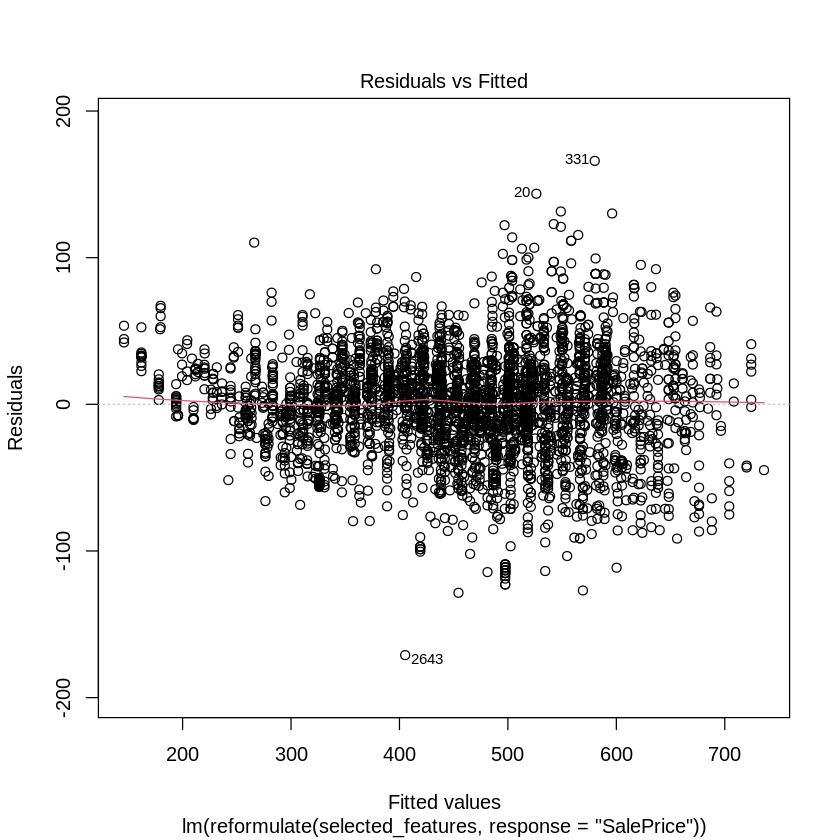

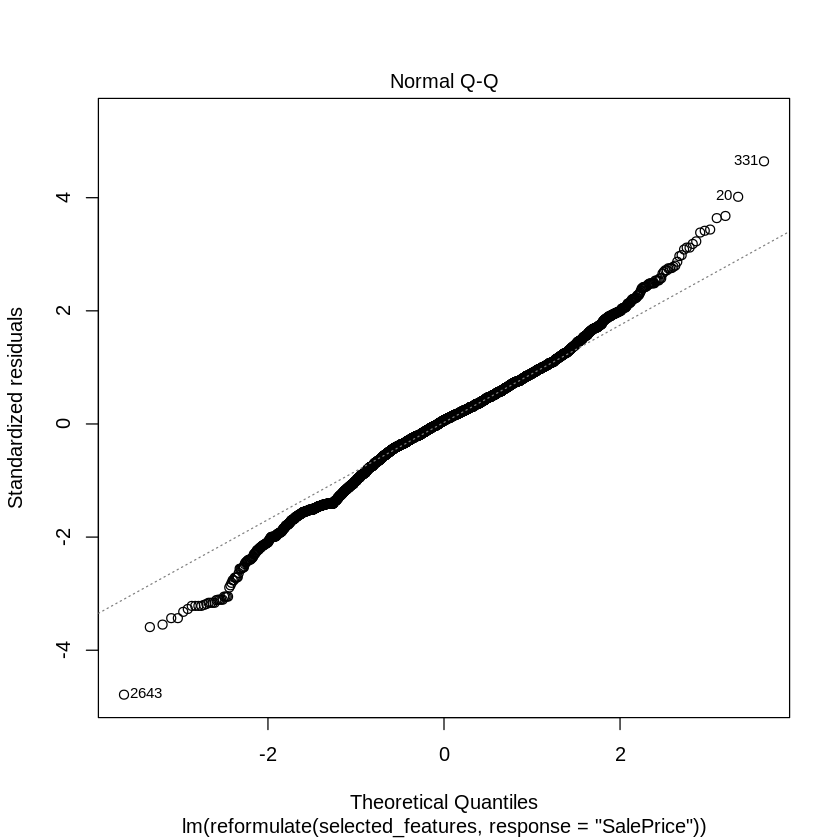

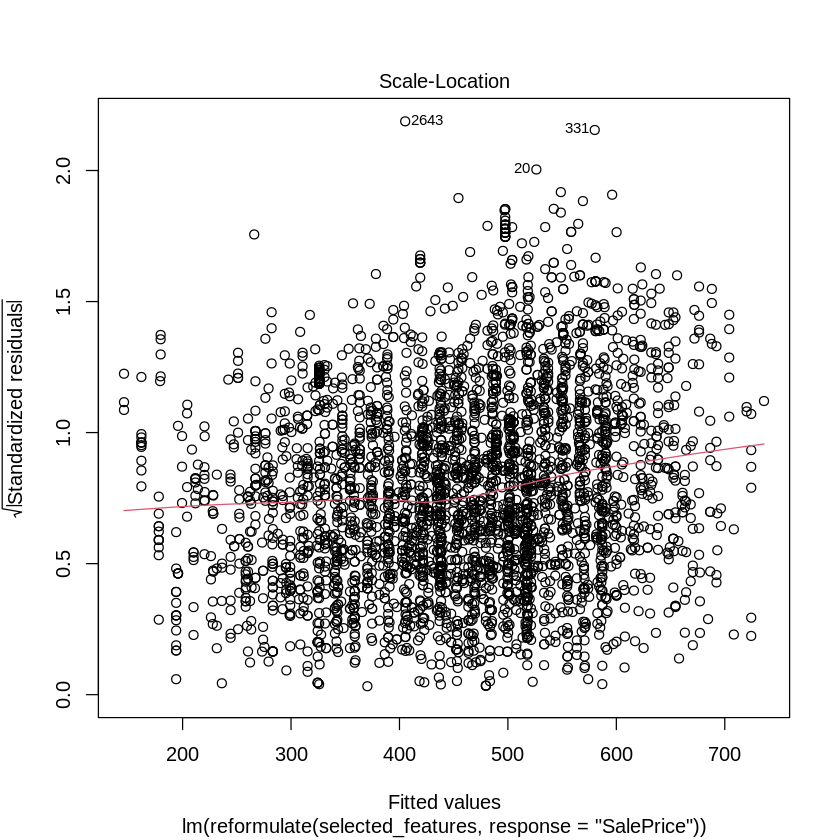

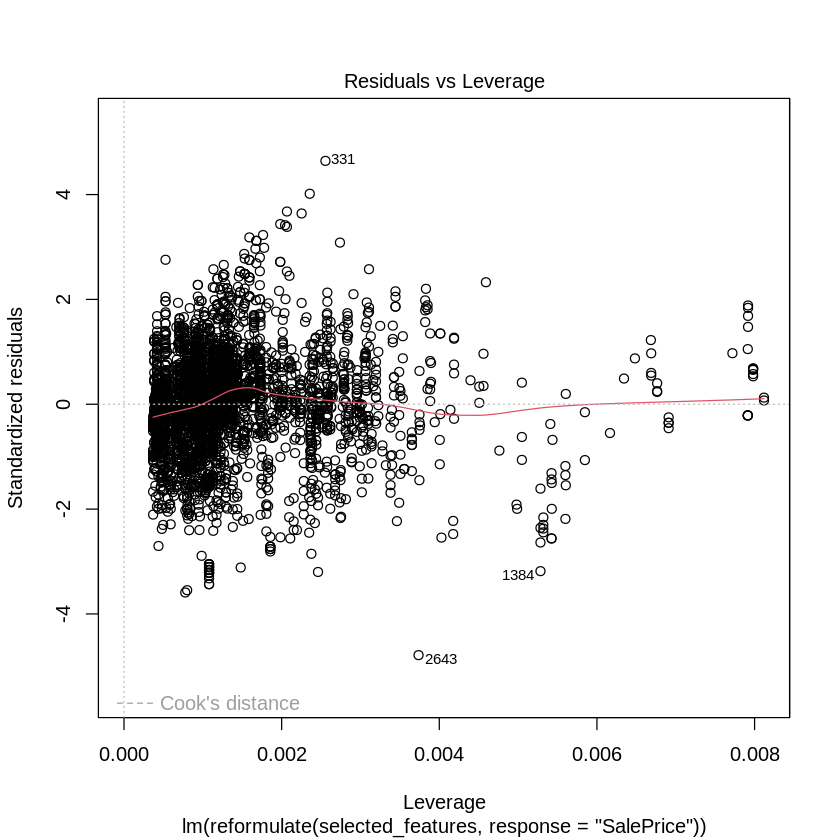

In [6]:
plot(modelo)

## Vif

In [7]:
#load the car library
library(car)

#calculate the VIF for each predictor variable in the model
vifs <- vif(modelo)
vifs

Loading required package: carData



YearBuilt                          YrSold 
                       1.400967                        1.059424 
`HallwayTypeterraced:Size.sqf.`                   log_Size.sqf. 
                       2.369344                        1.955088

In [8]:
# sqrt y
modelo_vif <- modelo

In [ ]:
# log y

dascartados <- selected_features == "log_Size.sqf."

selected_features <- selected_features[!dascartados]

modelo_vif <- lm(reformulate(selected_features, response = "SalePrice") , data = data_complete)
summary(modelo_vif)

In [ ]:
dascartados <- selected_features == "log_YrSold"

selected_features <- selected_features[!dascartados]

modelo_vif <- lm(reformulate(selected_features, response = "SalePrice") , data = data_complete)
summary(modelo_vif)

In [ ]:
vifs <- vif(modelo_vif)
vifs

## Heteroscedasticidad.

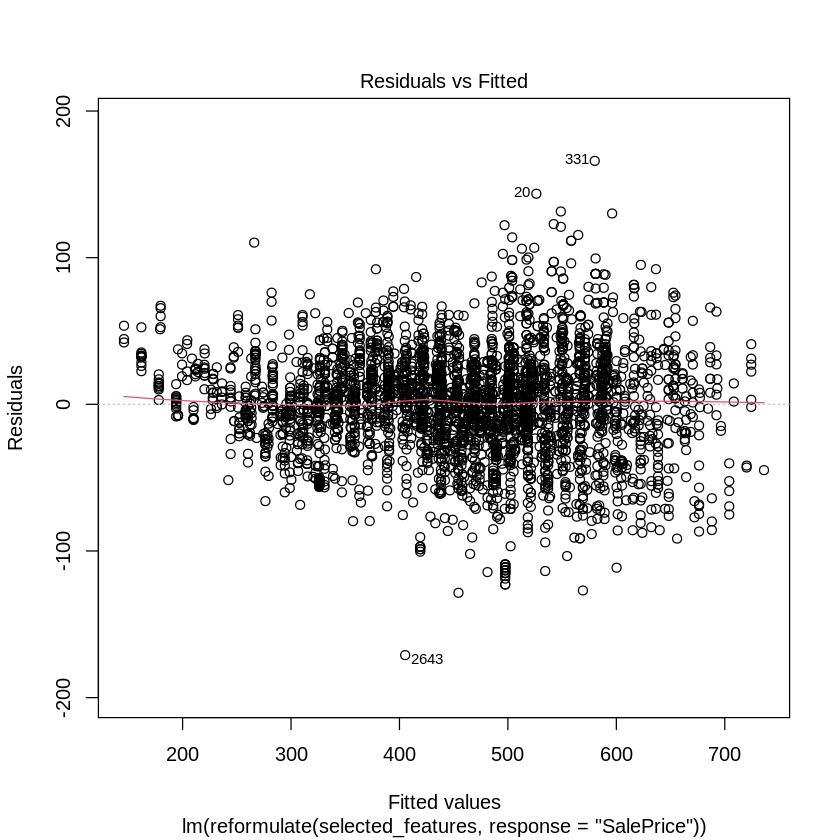

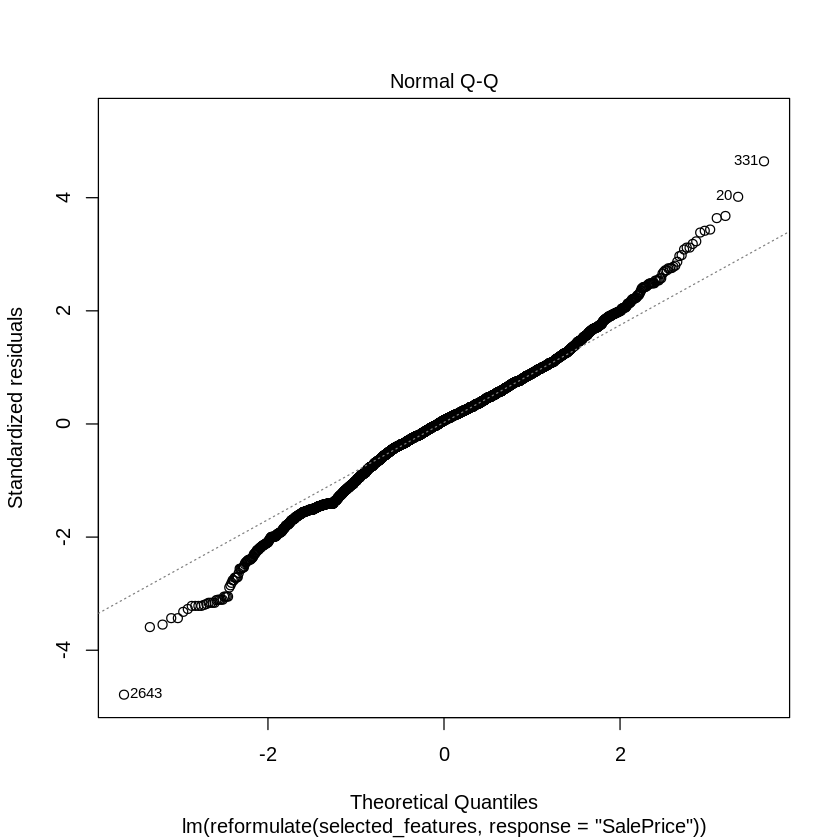

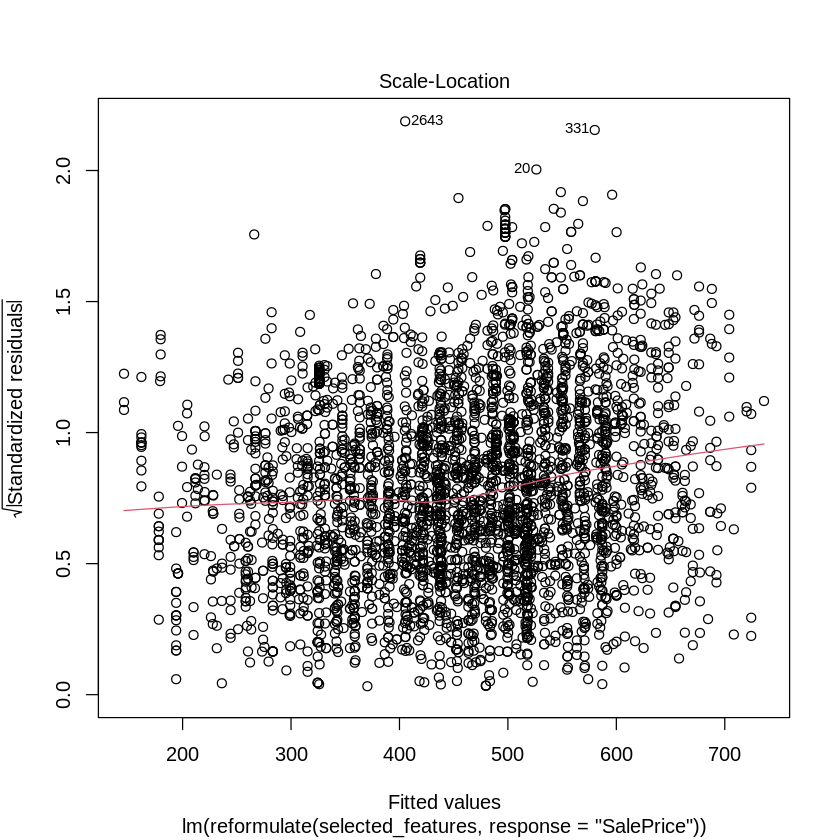

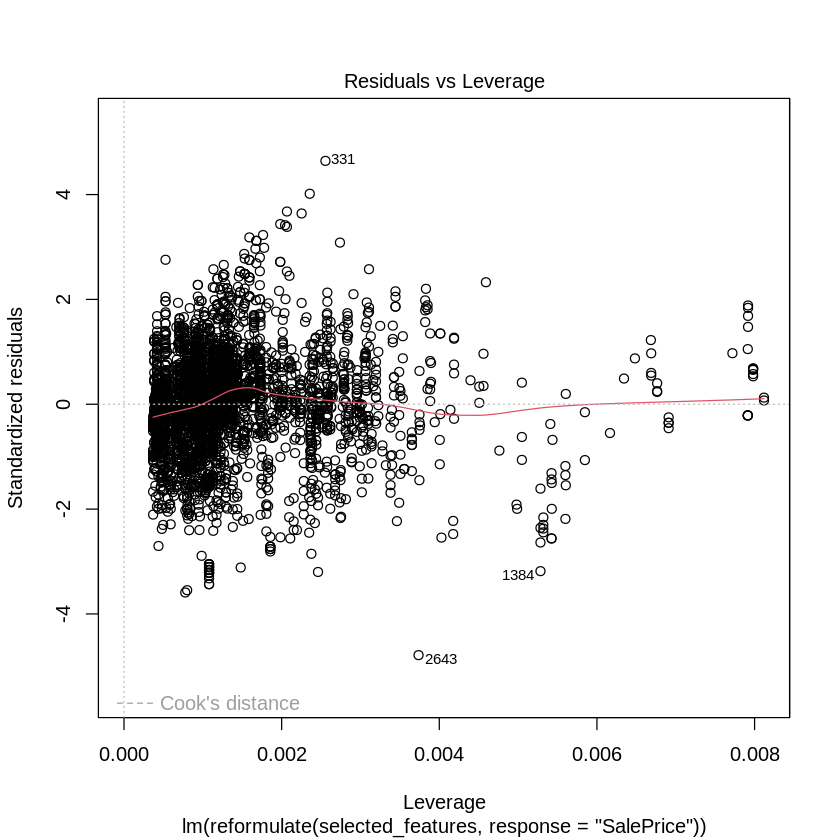

In [9]:
plot(modelo_vif)

In [10]:
library(lmtest)

#perform Breusch-Pagan Test
bptest(modelo_vif)

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric





	studentized Breusch-Pagan test

data:  modelo_vif
BP = 207.63, df = 4, p-value < 2.2e-16


[1] 0.7474747

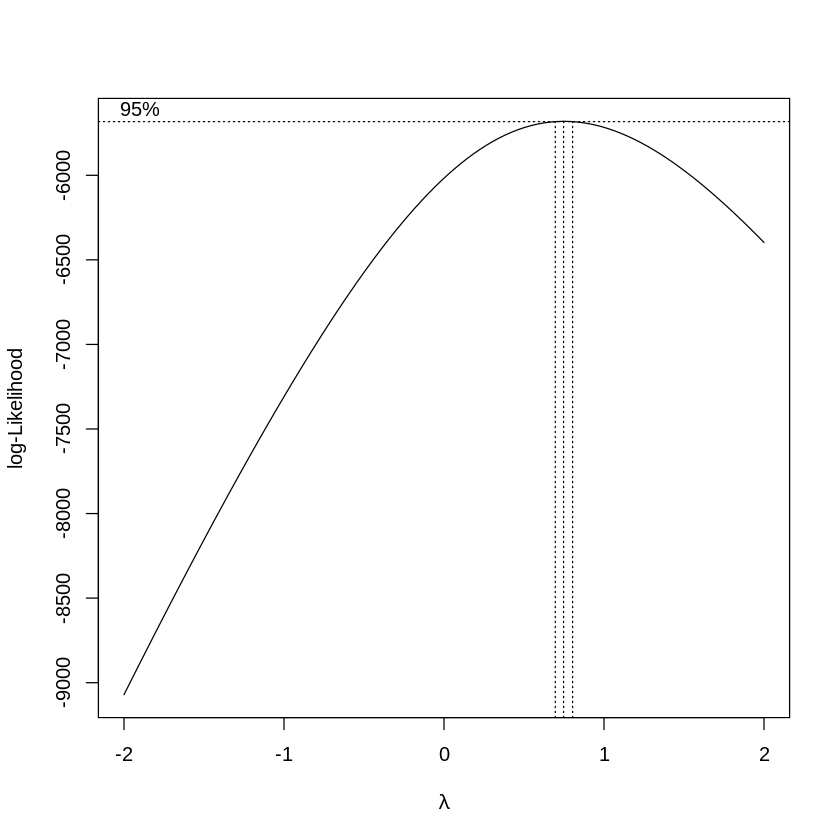

In [11]:
library(MASS)

bc_trans <- boxcox(modelo)
lambda <- bc_trans$x[which.max(bc_trans$y)]
lambda

In [17]:
data_complete["SalePrice"] <- (data_complete["SalePrice"] ^ lambda - 1) / lambda

In [18]:
modelo <- lm(reformulate(selected_features, response = "SalePrice") , data = data_complete)
summary(modelo)


Call:
lm(formula = reformulate(selected_features, response = "SalePrice"), 
    data = data_complete)

Residuals:
    Min      1Q  Median      3Q     Max 
-38.604  -4.212   0.536   4.644  31.890 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                     -8.796e+03  9.239e+01  -95.21   <2e-16 ***
YearBuilt                        8.606e-01  1.710e-02   50.32   <2e-16 ***
YrSold                           3.448e+00  4.538e-02   75.98   <2e-16 ***
`HallwayTypeterraced:Size.sqf.`  7.285e-03  3.320e-04   21.94   <2e-16 ***
log_Size.sqf.                    3.777e+01  4.330e-01   87.23   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 7.624 on 3599 degrees of freedom
  (6514 observations deleted due to missingness)
Multiple R-squared:  0.9074,	Adjusted R-squared:  0.9073 
F-statistic:  8816 on 4 and 3599 DF,  p-value: < 2.2e-16


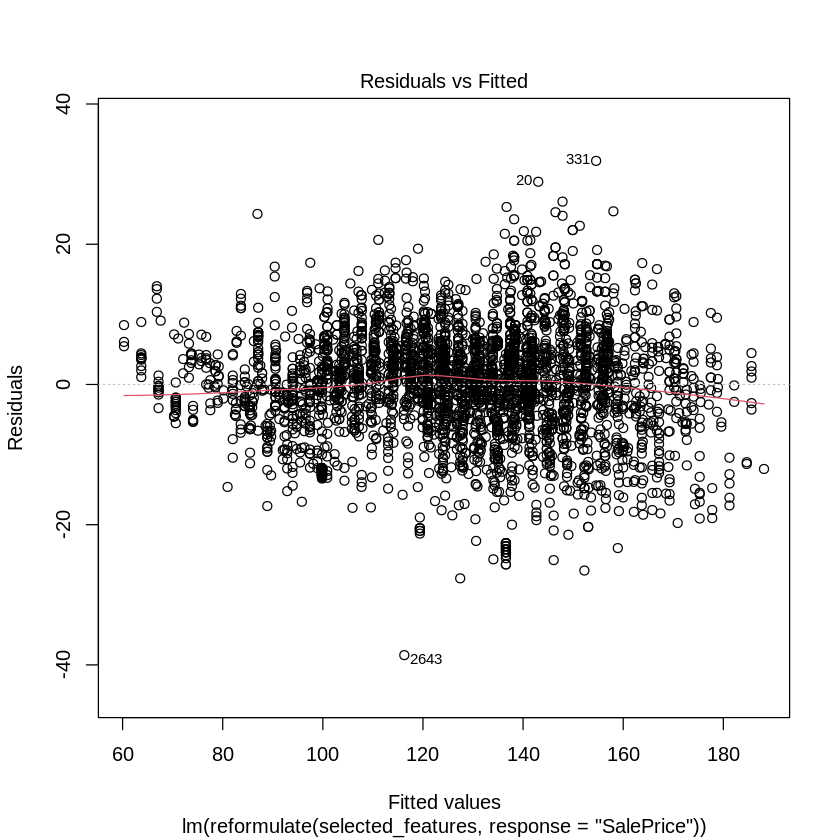

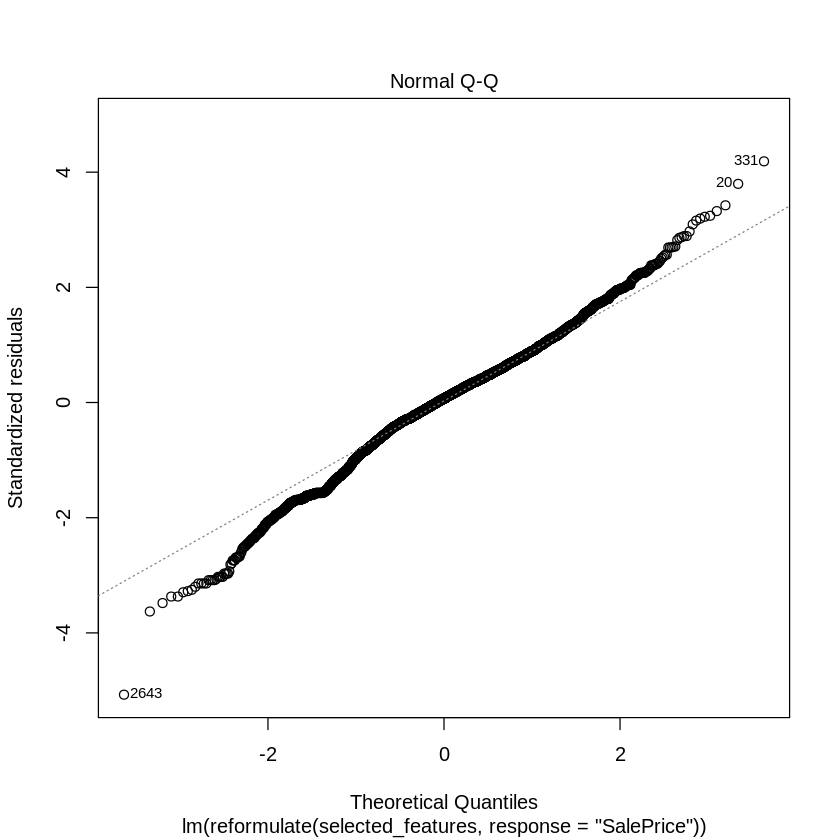

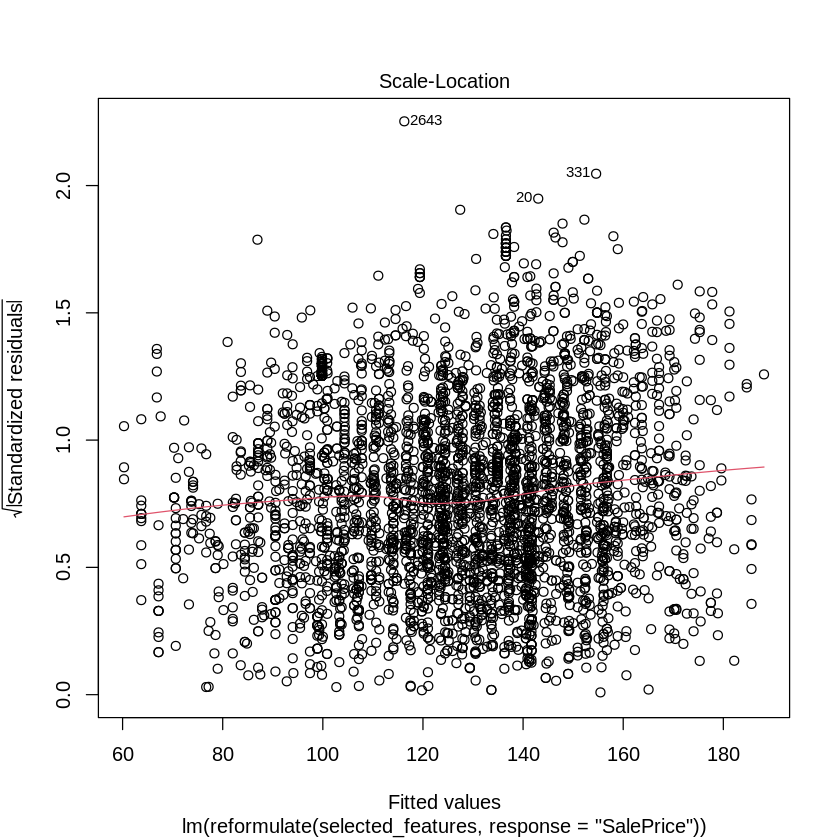

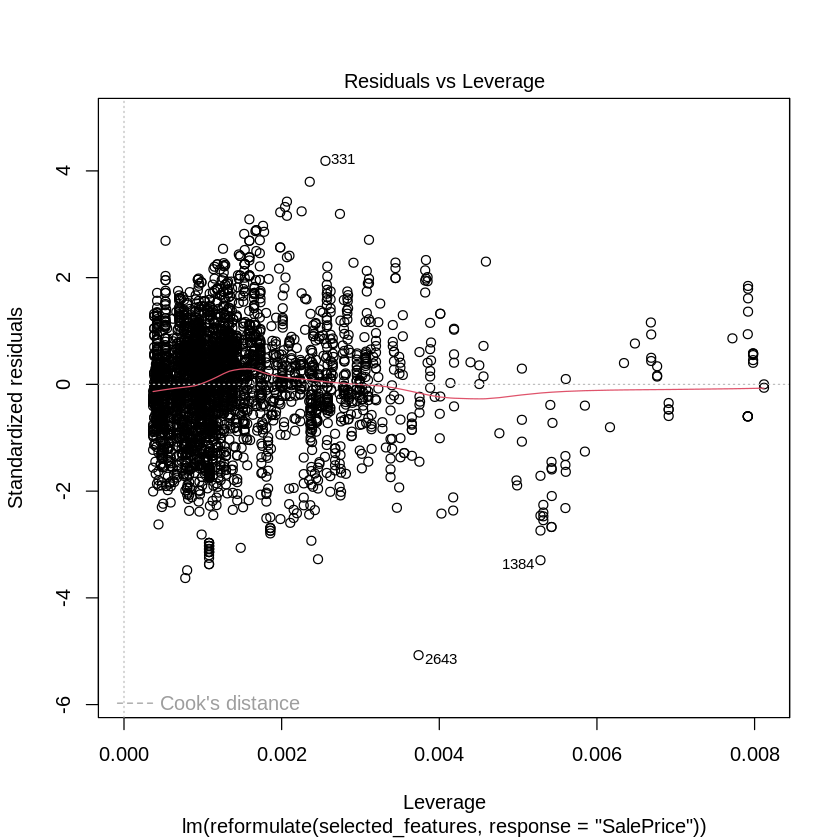

In [19]:
plot(modelo)

In [ ]:
#perform Breusch-Pagan Test
bptest(modelo)

Pese a nuestros mejores esfuerzos, el supuesto de heterocedasticidad no se cumple. Sugerimos un tratamiento más agresivo de outliers o un modelos generalizado con mejor ajuste.

### Normalidad

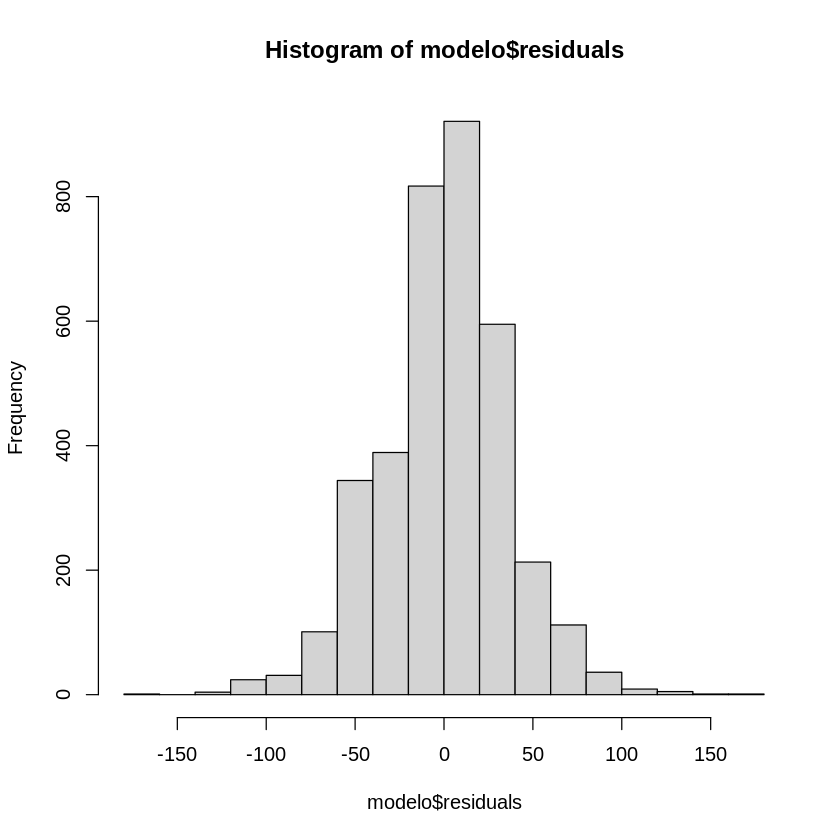

In [12]:
hist(modelo$residuals)

In [13]:
shapiro.test(modelo$residuals)



	Shapiro-Wilk normality test

data:  modelo$residuals
W = 0.99022, p-value = 4.699e-15


In [14]:
sm <- summary(modelos)

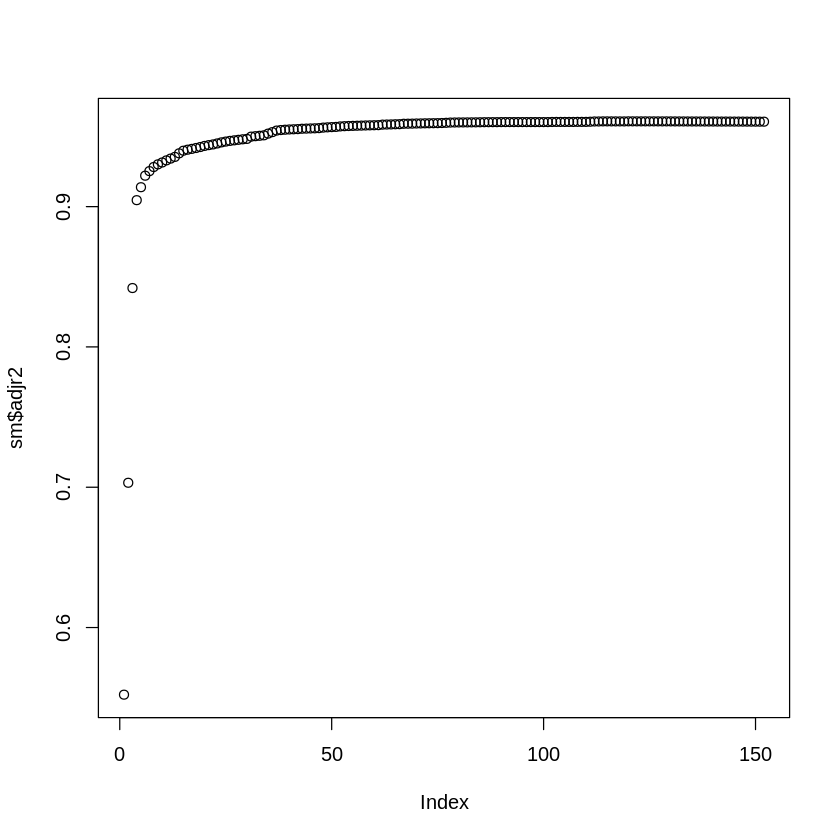

In [15]:
plot(sm$adjr2)

In [16]:
length(modelo$coefficients)

[1] 5

In [ ]:
data <- readr::read_csv("Archivos/Test real state.csv",
                        show_col_types = FALSE)

mapped_times <- list()
mapped_times['no_bus_stop_nearby'] <- 30
mapped_times['15min~20min'] <- 17.5
mapped_times['10min~15min'] <- 12.5
mapped_times['5min~10min'] <- 7.5
mapped_times['0~5min'] <- 2.5
mapped_times['0-5min'] <- 2.5

data$TimeToBusStop <- unlist(mapped_times[data$TimeToBusStop])
data$TimeToSubway <- unlist(mapped_times[data$TimeToSubway])

head(data)

In [ ]:
keep_outliers <- TRUE
data_complete <- as.data.frame(model.matrix(~ (SubwayStation + HallwayType + HeatingType)
                                                  * (.) - 1,
                                            data = data))
    
for (i in colnames(data_complete)) {
    name <- paste("log_", i, sep = "")
    data_complete[, name] <- log(data_complete[, i])
    name <- paste("squared_", i, sep = "")
    data_complete[, name] <- data_complete[, i] ^ 2
    name <- paste("inverse_", i, sep = "")
    data_complete[, name] <- 1 / data_complete[, i]
    name <- paste("sqrt_", i, sep = "")
    data_complete[, name] <- sqrt(data_complete[, i])
}

data_complete <- data_complete[keep_outliers, ]

In [ ]:
dim(data_complete)

In [ ]:
predicted <- data.frame(id = data[, "...1"], Predicted = numeric(length(data[, "...1"])))
predicted$Predicted <- unlist(predict(modelo, data_complete))

write.csv(predicted,                 # Name of variable assigned to the data       
         "Archivos/predicciones.csv",   # Name of the file to create to store the data
          row.names = TRUE)

In [ ]:
readr::read_csv("Archivos/Test real state.csv",
                        show_col_types = FALSE)
